In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from itertools import combinations
import csv
from scipy.signal import resample_poly
import umap
from scipy.stats import pearsonr

from pathlib import Path
import glob
import shutil
import os
import pickle


import sys
sys.path.append('/storage3/eva/code/neuropixels/src')
import path_formatting as pf
import motive
import oe

# use nma kernel cz umap works there. in motive doest really work

## CCG

In [3]:
date = "20250718"
animal = "eb02"

ks_path = rf'X:\eva\data\processed\{animal}\{animal}_{date}\kilosort'
ks_path = pf.w2l(ks_path)

res_path = rf'X:\eva\code\neuropixels\results\{animal}\{animal}_{date}'
res_path = pf.w2l(res_path)
# Create the folder if it doesn't exist
os.makedirs(res_path, exist_ok=True)

pa_path = Path(res_path) / "pa" #pa - populational analysis
pa_path.mkdir(parents=True, exist_ok=True) # Create the folder if it doesn't exist

ks_path, res_path, pa_path

('/storage3/eva/data/processed/eb02/eb02_20250718/kilosort',
 '/storage3/eva/code/neuropixels/results/eb02/eb02_20250718',
 PosixPath('/storage3/eva/code/neuropixels/results/eb02/eb02_20250718/pa'))

In [ ]:
#  return ccg_counts, bin_centers

In [4]:
# Load the file
res_path_path = Path(res_path)
with open(res_path_path / f"behav_periods_{animal}_{date}.pkl", "rb") as f:
    periods = pickle.load(f)

In [5]:
goodspiketimes = oe.ks_load(ks_path)
goodspiketimes

Sup! U have...
73 phy-good clusters


{7: array([   363390,    363620,    422287, ..., 610286566, 610290863,
        610299772], shape=(64900,)),
 19: array([     2581,      2885,      4972, ..., 610312373, 610316551,
        610317543], shape=(167810,)),
 26: array([   733767,   1858751,   1859074, ..., 605253151, 606121178,
        607909037], shape=(1885,)),
 45: array([  7270205,  10765890,  10767208, ..., 608805278, 608808180,
        610305349], shape=(3950,)),
 53: array([   107232,    107499,    107642,   7307193,   7846922,   7847193,
          9533020,   9533144,  16315470,  16315612,  17960347,  17960451,
         18919422,  19022585,  20025435,  20176426,  20421686,  20422758,
         20637817,  20643026,  22323920,  23021076,  23729667,  23824206,
         24068444,  24068554,  24596511,  24697691,  26877136,  27022918,
         28901523,  31812569,  31812830,  34446923,  34650696,  34650982,
         34908748,  34916666,  35096533,  35698650,  35763793,  35863392,
         36743673,  39001119,  39001362,  39

In [6]:
trial_keys = ['of1','of2','of3']
trials = [f'{date}_2',f'{date}_4',f'{date}_6']

1. I wanna find units of interest with overlapping place fields

In [7]:
# Load pf
pf_path = Path(res_path) / "pf"

pf_dict = {}

for i, trial_key in enumerate(trial_keys):

    with open(f"{pf_path}/place_fields_{trial_key}_ses_{trials[i]}.pkl", "rb") as f:
        place_fields = pickle.load(f)
    pf_dict[trial_key] = place_fields

In [10]:
pf_dict

{'of1': {7: array([[ 0.16264347,  0.1400846 ,  0.10258201,  0.10047865,  0.19878463,
           0.37969582,  0.66607325,  1.12780412,  1.97061975,  2.51841992,
           2.47967502,  2.69266495,  4.49538558,  8.76403232, 13.83135665,
          17.64226118, 19.16065303, 15.52597847,  8.64886143,  3.13005529,
           0.87372999],
         [ 0.11580257,  0.13121711,  0.147201  ,  0.18449958,  0.29052004,
           0.4551768 ,  0.65870412,  0.92224815,  1.34441829,  1.69840786,
           2.10209282,  3.16490301,  6.0643598 , 11.57077116, 17.33986567,
          21.00719703, 20.54671427, 15.41874637,  8.34598312,  2.93173712,
           0.80883874],
         [ 0.12566951,  0.29841197,  0.48949035,  0.5333615 ,  0.57538929,
           0.66963317,  0.65806395,  0.69730261,  0.9047718 ,  1.30642086,
           2.10554574,  3.93433186,  8.09050023, 14.66621441, 20.42547574,
          23.0854622 , 21.13976997, 15.30484433,  7.8174597 ,  2.56079309,
           0.69380598],
         [ 0.15184

In [15]:
def skaggs_sparsity(pf_map):
    """Compute Skaggs spatial sparsity for a rate map."""
    f = pf_map.flatten()
    if np.all(np.isnan(f)):
        return np.nan
    # Treat NaNs as zero-occupancy bins
    f = np.nan_to_num(f, nan=0.0)

    # Uniform occupancy assumption (if real occupancy not available)
    p = np.ones_like(f) / len(f)

    mean_rate = np.sum(p * f)
    if mean_rate == 0:
        return np.nan

    sparsity = (np.sum(p * f) ** 2) / np.sum(p * (f ** 2))
    return sparsity

In [13]:
def normalize_map(pf_map):
    """Z-score normalization, ignoring NaNs."""
    m = np.nanmean(pf_map)
    s = np.nanstd(pf_map)
    if s == 0 or np.isnan(s):
        return pf_map * 0  # all zeros if no variance
    return (pf_map - m) / s

In [41]:
def top_correlated_pairs(pf_dict, top_n=10, sparsity_cutoff=0.5):
    results = {}
    for trial_key, units_maps in pf_dict.items():
        pairs = []
        units = list(units_maps.keys())
        for u1, u2 in combinations(units, 2):
            s1 = skaggs_sparsity(units_maps[u1])
            s2 = skaggs_sparsity(units_maps[u2])

            # Skip high-sparsity (non-selective) maps
            if np.isnan(s1) or np.isnan(s2):
                continue
            if s1 > sparsity_cutoff or s2 > sparsity_cutoff:
                continue

            # Normalize before correlation
            m1 = normalize_map(units_maps[u1])
            m2 = normalize_map(units_maps[u2])

            # Flatten and mask NaNs
            f1, f2 = m1.flatten(), m2.flatten()
            mask = ~np.isnan(f1) & ~np.isnan(f2)
            if mask.sum() < 2:
                continue

            r, _ = pearsonr(f1[mask], f2[mask])
            pairs.append((u1, u2, r, s1, s2))

        # Sort by correlation
        pairs_sorted = sorted(pairs, key=lambda x: x[2], reverse=True)
        results[trial_key] = pairs_sorted[:top_n]
    return results

In [42]:
top_pairs = top_correlated_pairs(pf_dict, top_n=10, sparsity_cutoff=0.5)

In [19]:
for trial, pairs in top_pairs.items():
    print(f"\n{trial} top correlated pairs (with sparsity values):")
    for u1, u2, r, s1, s2 in pairs:
        print(f"Units {u1}-{u2}: r={r:.3f}, sparsity={s1:.3f}/{s2:.3f}")


of1 top correlated pairs (with sparsity values):
Units 53-56: r=1.000, sparsity=0.046/0.046
Units 53-194: r=1.000, sparsity=0.046/0.046
Units 53-546: r=1.000, sparsity=0.046/0.046
Units 56-194: r=1.000, sparsity=0.046/0.046
Units 56-546: r=1.000, sparsity=0.046/0.046
Units 194-546: r=1.000, sparsity=0.046/0.046
Units 195-441: r=1.000, sparsity=0.037/0.037
Units 473-513: r=0.976, sparsity=0.055/0.054
Units 195-474: r=0.942, sparsity=0.037/0.047
Units 441-474: r=0.942, sparsity=0.037/0.047

of2 top correlated pairs (with sparsity values):
Units 79-457: r=0.964, sparsity=0.059/0.067
Units 470-475: r=0.953, sparsity=0.029/0.027
Units 434-458: r=0.897, sparsity=0.107/0.067
Units 430-457: r=0.843, sparsity=0.159/0.067
Units 79-430: r=0.838, sparsity=0.059/0.159
Units 441-446: r=0.838, sparsity=0.079/0.188
Units 56-545: r=0.808, sparsity=0.049/0.230
Units 512-516: r=0.790, sparsity=0.065/0.097
Units 232-233: r=0.774, sparsity=0.092/0.097
Units 167-189: r=0.764, sparsity=0.133/0.325

of3 top 

In [46]:
unique_pairs = set()
for trial_pairs in top_pairs.values():
    for p in trial_pairs:
        pair = tuple(sorted(p[:2]))  # sort so (53,56) == (56,53)
        unique_pairs.add(pair)

# turn into list if needed
unique_pairs_list = list(unique_pairs)
print(unique_pairs_list)

[(53, 194), (79, 457), (441, 446), (189, 475), (53, 56), (83, 457), (56, 546), (256, 470), (472, 546), (195, 475), (434, 458), (470, 475), (195, 441), (137, 427), (137, 195), (194, 546), (53, 546), (474, 475), (473, 513), (56, 545), (430, 457), (195, 474), (56, 194), (68, 476), (79, 430), (167, 189), (512, 516), (441, 474), (232, 233)]


In [65]:
def ccg(spike_times_1, spike_times_2, bin_size_ms=20.0, max_lag_ms=1000.0, fs=30000,
        exclude_zero_lag=False, zero_exclusion_ms=None):
    """
    Cross-correlogram between two spike trains (spike times in *samples*).

    If exclude_zero_lag=True, bins with |lag| < zero_exclusion_ms are zeroed.
    By default, zero_exclusion_ms = bin_size_ms/2 (i.e., the central bin).

    Returns
    -------
    lags_ms : np.ndarray
        Bin centers in milliseconds.
    counts : np.ndarray
        Counts per lag bin.
    """
    # sort & convert to seconds
    s1 = np.sort(np.asarray(spike_times_1)) / fs
    s2 = np.sort(np.asarray(spike_times_2)) / fs

    max_lag_s = max_lag_ms / 1000.0
    bin_edges_ms = np.arange(-max_lag_ms, max_lag_ms + bin_size_ms, bin_size_ms)
    counts = np.zeros(len(bin_edges_ms) - 1, dtype=np.int64)

    # two-sided windowed differences via searchsorted (efficient)
    for t in s1:
        lo = t - max_lag_s
        hi = t + max_lag_s
        i0 = np.searchsorted(s2, lo, side='left')
        i1 = np.searchsorted(s2, hi, side='right')
        diffs_ms = (s2[i0:i1] - t) * 1000.0  # ms
        c, _ = np.histogram(diffs_ms, bins=bin_edges_ms)
        counts += c

    lags_ms = 0.5 * (bin_edges_ms[:-1] + bin_edges_ms[1:])

    # Exclude zero-lag like an ACG
    if exclude_zero_lag:
        if zero_exclusion_ms is None:
            zero_exclusion_ms = bin_size_ms / 2.0
        mask = np.abs(lags_ms) < zero_exclusion_ms
        counts[mask] = 0

    return lags_ms, counts

In [68]:
ccgs = {}
for pair in unique_pairs:
    lags_ms, counts = ccg(goodspiketimes[pair[0]],goodspiketimes[pair[1]],bin_size_ms=1.0,max_lag_ms=100.0,)
    ccgs[pair] = [lags_ms, counts]

In [62]:
ccgs = {}
for pair in unique_pairs:
    lags_ms, counts = oe.ccg(goodspiketimes[pair[0]],goodspiketimes[pair[1]],bin_size_ms=1.0)
    ccgs[pair] = [lags_ms, counts]

In [ ]:
def acg_ccg(spike_times_1, spike_times_2, bin_size_ms=1.0, max_lag_ms=100.0, fs=30000):
    """
    Autocorrelogram for a single spike train (excludes zero-lag self-pairs).
    Spike times are in *samples*.
    """
    s1 = np.sort(np.asarray(spike_times_1)) / fs  # seconds
    s2 = np.sort(np.asarray(spike_times_2)) / fs
    max_lag_s = max_lag_ms / 1000.0
    bin_edges_ms = np.arange(-max_lag_ms, max_lag_ms + bin_size_ms, bin_size_ms)
    counts = np.zeros(len(bin_edges_ms) - 1, dtype=np.int64)

    for i, t in enumerate(s):
        lo = t - max_lag_s
        hi = t + max_lag_s
        # find neighbors excluding the spike itself (strict inequalities)
        j0 = np.searchsorted(s, lo, side='left')
        j1 = np.searchsorted(s, hi, side='right')
        # exclude index i
        neigh = np.concatenate((s[j0:i], s[i+1:j1]))
        diffs_ms = (neigh - t) * 1000.0
        c, _ = np.histogram(diffs_ms, bins=bin_edges_ms)
        counts += c

    lags_ms = 0.5 * (bin_edges_ms[:-1] + bin_edges_ms[1:])
    return lags_ms, counts

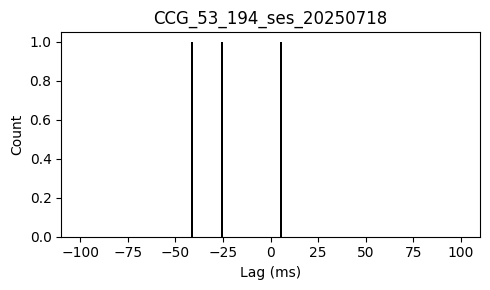

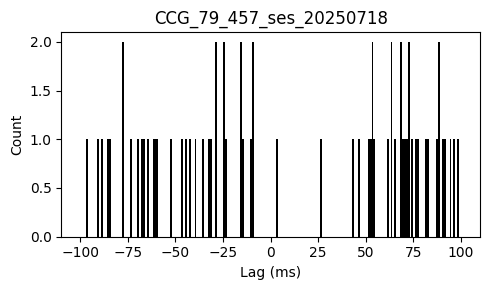

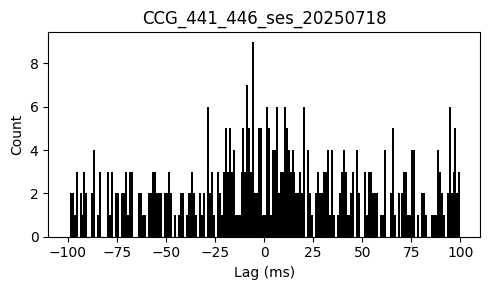

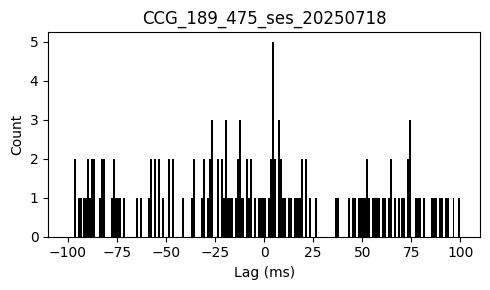

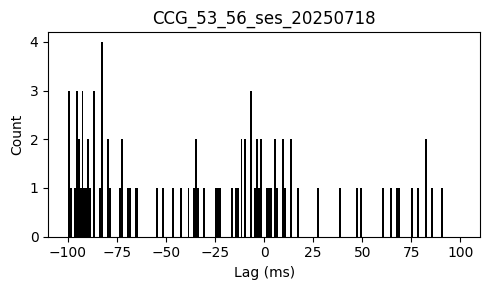

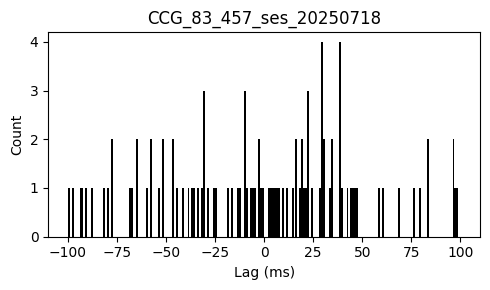

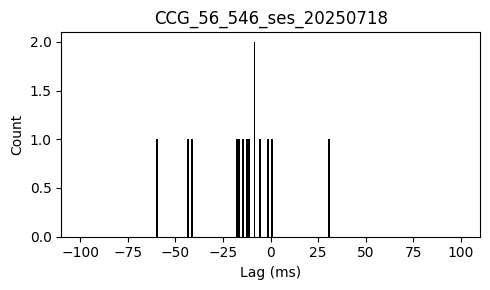

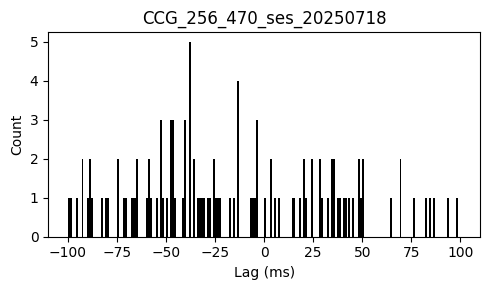

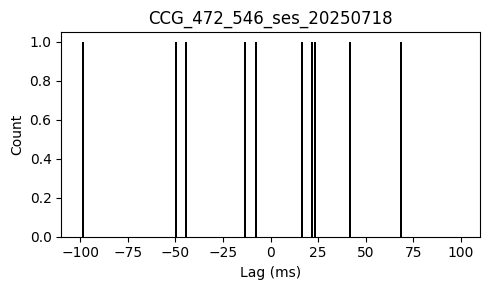

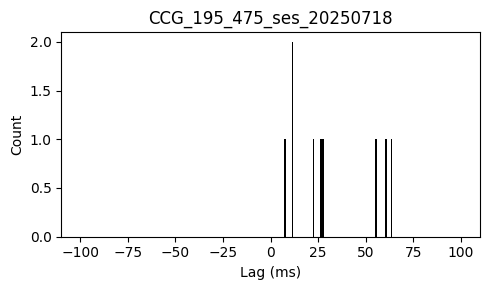

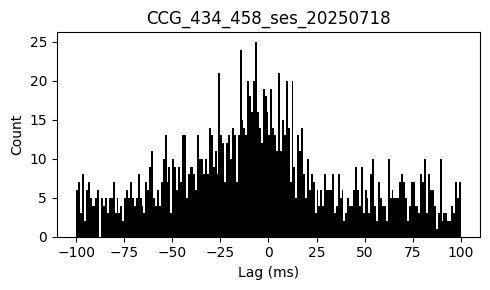

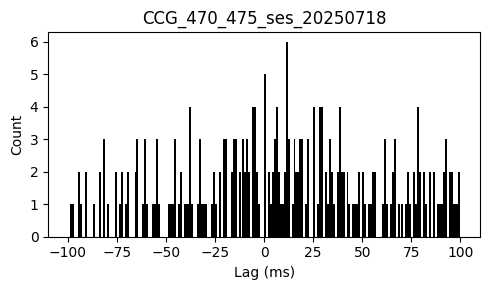

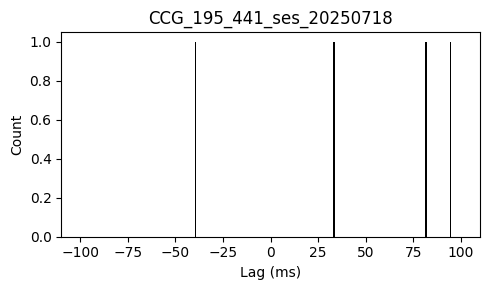

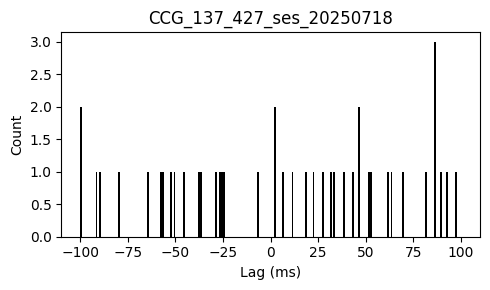

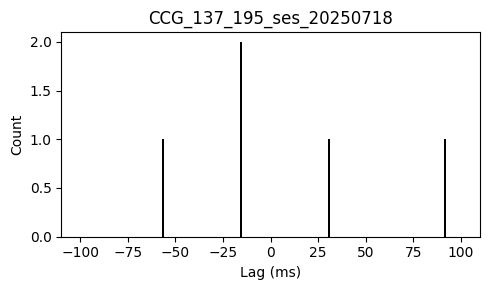

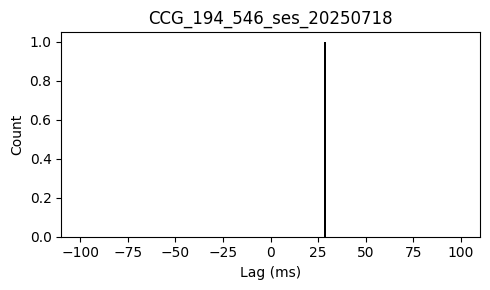

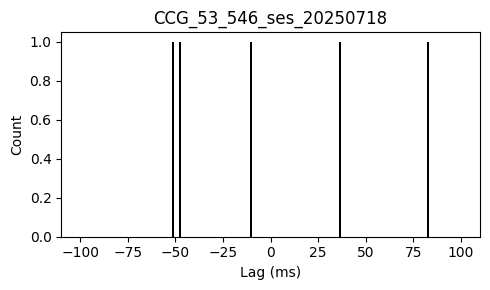

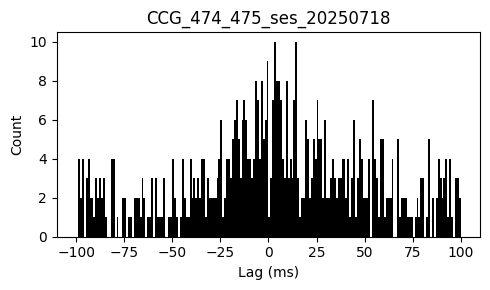

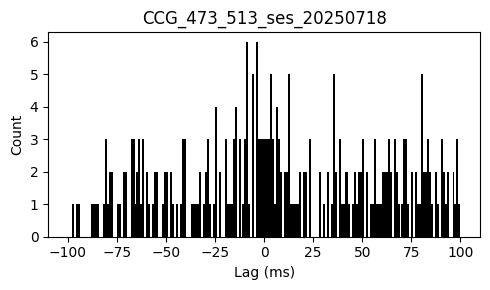

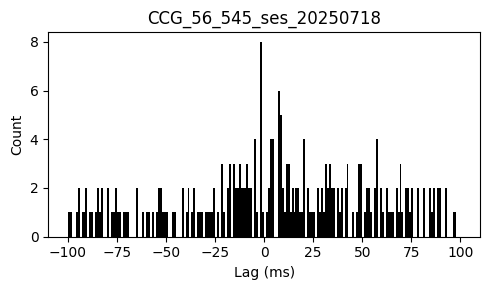

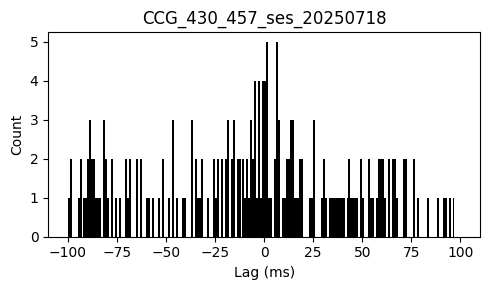

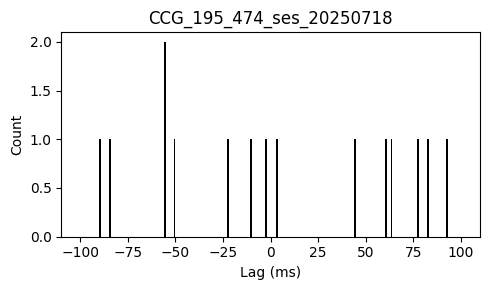

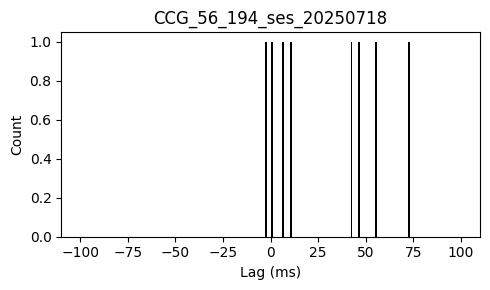

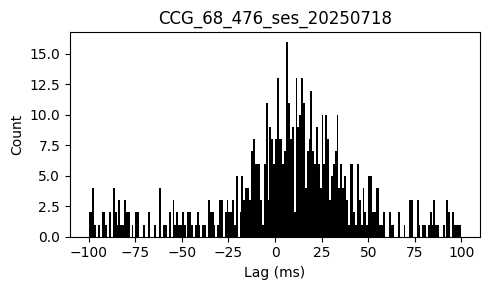

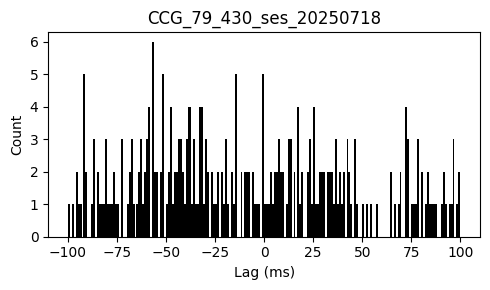

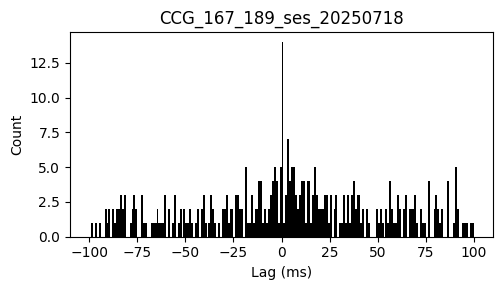

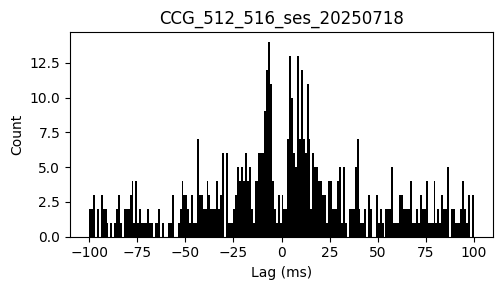

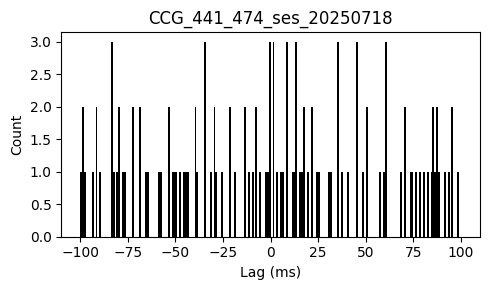

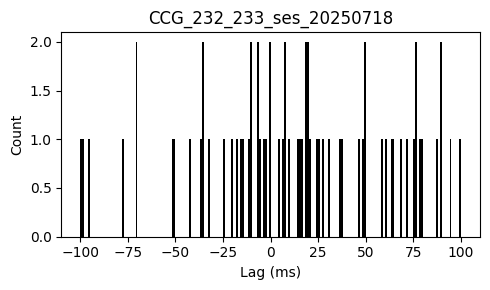

In [69]:
for pair in unique_pairs:

    lags, counts = ccgs[pair][0], ccgs[pair][1]

    plt.figure(figsize=(5, 3))
    plt.bar(lags, counts, width=1, color='black')

    filename = f'CCG_{pair[0]}_{pair[1]}_ses_{date}'
    plt.title(filename)
    plt.xlabel('Lag (ms)')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

In [71]:
def plot_ccg(u1, u2, save=True):
    fig, axes = plt.subplots(1, len(trial_keys), figsize=(5 * len(trial_keys), 3), sharey=True)

    for ax, trial_key in zip(axes, trial_keys):
        start, end = periods[trial_key]
        goodspiketimes_period = {
            unit: spikes[(spikes >= start) & (spikes <= end)] - start
            for unit, spikes in goodspiketimes.items()
        }
        print(f'in {trial_key} {len(list(goodspiketimes_period))} units')

        t1 = goodspiketimes_period[u1]
        t2 = goodspiketimes_period[u2]

        ccg_counts, bin_centers = compute_ccg_samples(t1, t2)

        # Convert to ms
        bin_centers_ms = bin_centers * 1000

        # Optional normalization
        ccg_norm = ccg_counts / ccg_counts.sum()
        # ccg_norm = ccg_counts/(bin_size_s*len(t1)*len(t2))

        ax.bar(bin_centers_ms, ccg_norm, width=10, color='black')  # width=1.0 ms
        ax.set_title(f'{trial_key}')
        ax.set_xlabel('Lag (ms)')
        if ax == axes[0]:
            ax.set_ylabel('Normalized Count')

    filename = f'CCG_units_{u1}_and_{u2}_{date}'

    plt.suptitle(filename, fontsize=14)

    if save:
        res_path_path = Path(res_path)
        plt.savefig(res_path_path / f"{filename}.png", dpi=300, bbox_inches='tight')


    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

In [69]:
def plot_ccg(u1, u2, save=True):
    fig, axes = plt.subplots(1, len(trial_keys), figsize=(5 * len(trial_keys), 3), sharey=True)

    # Precompute global max for consistent y-axis
    max_vals = []
    for trial_key in trial_keys:
        start, end = periods[trial_key]
        goodspiketimes_period = {
            unit: spikes[(spikes >= start) & (spikes <= end)] - start
            for unit, spikes in goodspiketimes.items()
        }
        if u1 in goodspiketimes_period and u2 in goodspiketimes_period:
            t1 = goodspiketimes_period[u1]
            t2 = goodspiketimes_period[u2]
            ccg_counts, _ = compute_ccg_samples(t1, t2)
            norm = ccg_counts / (bin_size_s * len(t1) * len(t2))
            max_vals.append(np.max(norm))
    y_max = max(max_vals) if max_vals else 1

    for ax, trial_key in zip(axes, trial_keys):
        start, end = periods[trial_key]
        goodspiketimes_period = {
            unit: spikes[(spikes >= start) & (spikes <= end)] - start
            for unit, spikes in goodspiketimes.items()
        }
        print(f'in {trial_key} {len(list(goodspiketimes_period))} units')

        if u1 not in goodspiketimes_period or u2 not in goodspiketimes_period:
            ax.set_title(f'{trial_key}\nunit missing')
            ax.set_xticks([])
            ax.set_yticks([])
            continue

        t1 = goodspiketimes_period[u1]
        t2 = goodspiketimes_period[u2]

        ccg_counts, bin_centers = compute_ccg_samples(t1, t2)
        bin_centers_ms = bin_centers * 1000
        #ccg_norm = ccg_counts / (bin_size_s * len(t1) * len(t2))
        ccg_norm = ccg_counts

        ax.bar(bin_centers_ms, ccg_norm, width=10, color='black')
        ax.set_title(f'{trial_key}')
        ax.set_xlabel('Lag (ms)')
        ax.set_ylim(0, y_max * 1.05)

        if ax == axes[0]:
            ax.set_ylabel('Normalized Count')

    filename = f'CCG_units_{u1}_and_{u2}_{date}'
    plt.suptitle(filename, fontsize=14)

    if save:
        res_path_path = Path(res_path)
        plt.savefig(res_path_path / f"{filename}.png", dpi=300, bbox_inches='tight')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

in of1 99 units
in of2 99 units
in of3 99 units


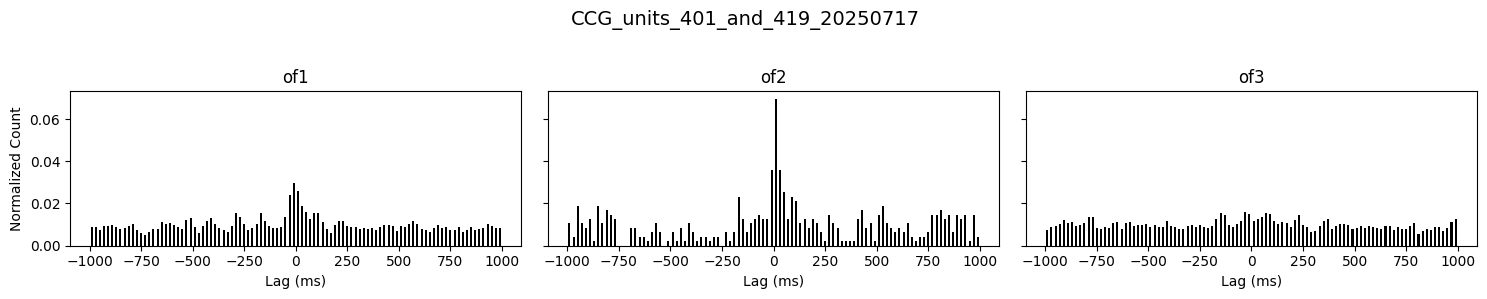

In [77]:
plot_ccg(401,419)

in of1 99 units
in of2 99 units
in of3 99 units


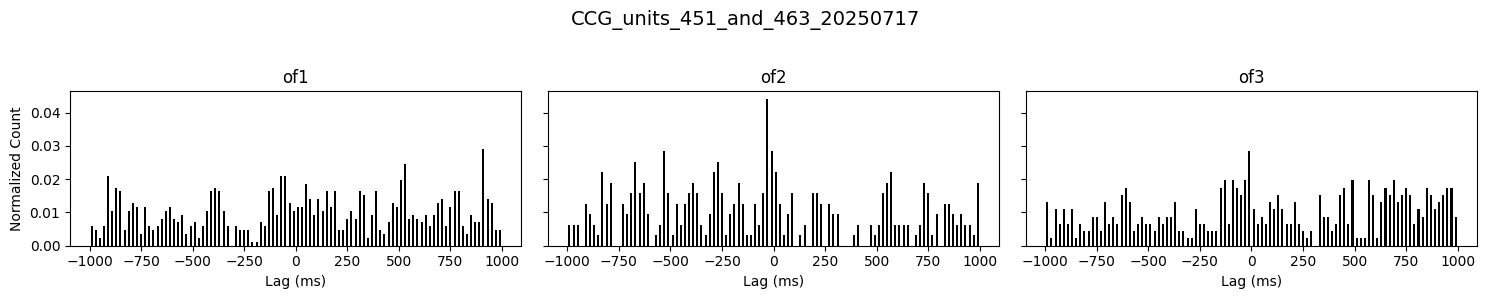

In [78]:
plot_ccg(451,463)

in of1 99 units
in of2 99 units
in of3 99 units


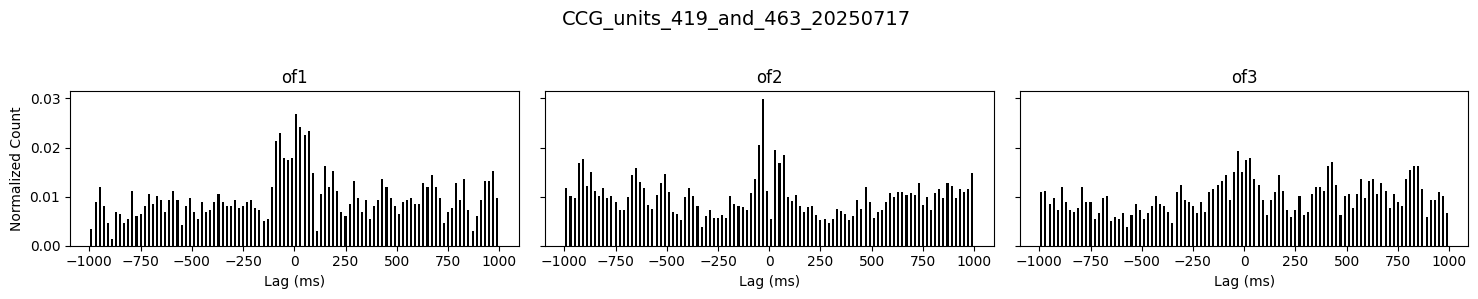

In [79]:
plot_ccg(419,463)

in of1 99 units
in of2 99 units
in of3 99 units


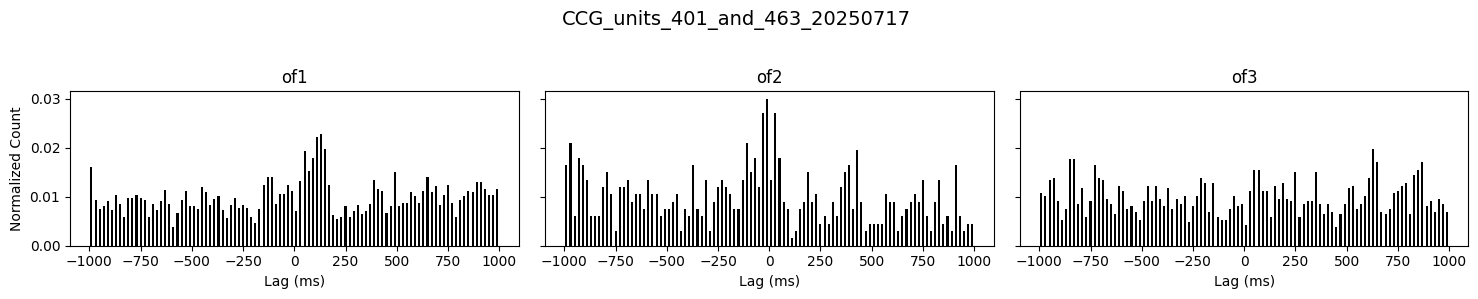

In [80]:
plot_ccg(401,463)